In [4]:
# Install if not already installed (uncomment to run)
# !pip install vaderSentiment textblob nltk sklearn

import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\selam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
df = pd.read_csv('../data/processed/cleaned_reviews.csv')  # Adjust path if needed
df.head()


,review,rating,date,bank,source
0,what is this app problem???,1,2025-06-05,Commercial Bank of Ethiopia,Google Play
1,the app is proactive and a good connections.,5,2025-06-05,Commercial Bank of Ethiopia,Google Play
2,I cannot send to cbebirr app. through this app.,3,2025-06-05,Commercial Bank of Ethiopia,Google Play
3,good,4,2025-06-05,Commercial Bank of Ethiopia,Google Play
4,not functional,1,2025-06-05,Commercial Bank of Ethiopia,Google Play


In [11]:
# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# VADER sentiment scores
df['vader_compound'] = df['review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# TextBlob polarity
df['textblob_polarity'] = df['review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Classify sentiment based on VADER compound score
def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['vader_compound'].apply(classify_sentiment)

print(df['sentiment'].value_counts())


sentiment
positive    638
neutral     306
negative    176
Name: count, dtype: int64


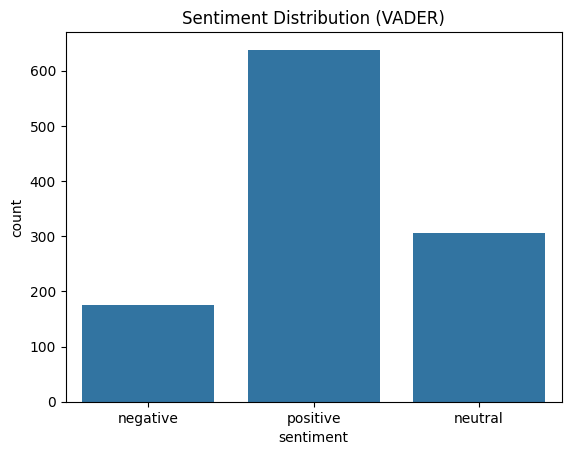

In [12]:
sns.countplot(data=df, x='sentiment')
plt.title('Sentiment Distribution (VADER)')
plt.show()


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Use TF-IDF Vectorizer on review content
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['review'])  # <-- assign this

# Use NMF for topic modeling
nmf = NMF(n_components=5, random_state=42)
nmf.fit(tfidf)

# Display top keywords per topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}: ", end='')
        print(" + ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
display_topics(nmf, tfidf_feature_names, 7)



Topic 0: app + worst + banking + amazing + great + mobile + work
Topic 1: good + application + job + work + need + bad + service
Topic 2: best + banking + application + mobile + seen + loved + bank
Topic 3: nice + apps + bank + service + application + wish + aplication
Topic 4: easy + use + bank + fast + dashen + super + reliable


In [19]:
topic_values = nmf.transform(tfidf)
df['dominant_topic'] = topic_values.argmax(axis=1)
df[['review', 'dominant_topic']].head(10)


,review,dominant_topic
0,what is this app problem???,0
1,the app is proactive and a good connections.,1
2,I cannot send to cbebirr app. through this app.,0
3,good,1
4,not functional,0
5,everytime you uninstall the app you have to re...,0
6,mr space,0
7,best,2
8,bezabih,0
9,Best Mobile Banking app ever,2


In [20]:
import numpy as np

# Assign topics to reviews
topic_values = nmf.transform(tfidf)  # Get topic distribution per review
df['topic'] = np.argmax(topic_values, axis=1)

# Show number of reviews per topic
print(df['topic'].value_counts())

# Sentiment distribution per topic
sentiment_topic = df.groupby(['topic', 'sentiment']).size().unstack(fill_value=0)
print(sentiment_topic)


topic
0    436
4    431
1    124
2     79
3     50
Name: count, dtype: int64
sentiment  negative  neutral  positive
topic                                 
0               101      176       159
1                13        7       104
2                 2        2        75
3                 3        5        42
4                57      116       258


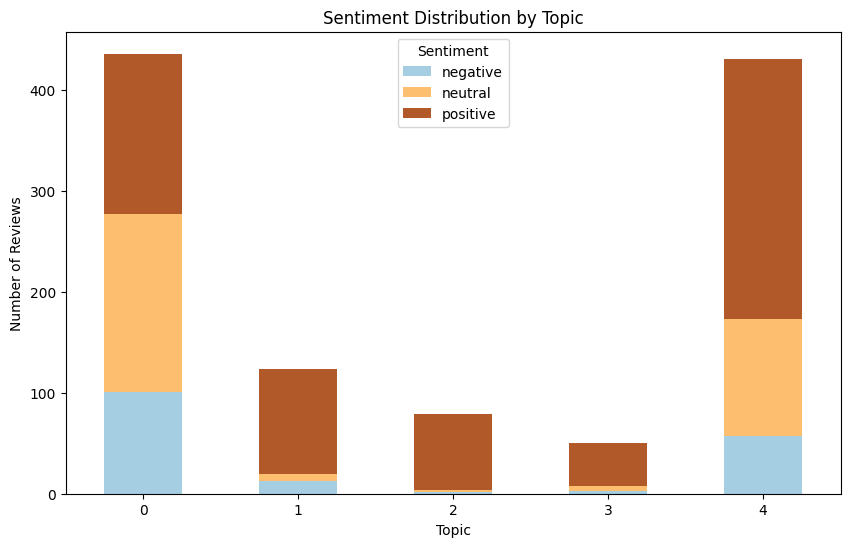

In [21]:
import matplotlib.pyplot as plt

sentiment_topic.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Paired')
plt.title('Sentiment Distribution by Topic')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.show()


In [1]:
from transformers import pipeline

# Load the sentiment analysis pipeline
sentiment_model = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")


ModuleNotFoundError: No module named 'transformers'